# Visualization - exploring the data

Let's begin with the imports...

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

from utils import load_corpus, split_train_test, getSceneData

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the corpus into a DataFrame, and create a separate DataFrame for the 4 main characters.

In [3]:
df = load_corpus()
df_main_characters = df[df['character'].isin(["JERRY", "ELAINE", "KRAMER", "GEORGE"])]

Let's see how each entry in our DataFrame looks like...

In [4]:
df.head(3)

,avg_word_length,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,num_words,season,start,total_lines,txt,global_episode_num
0,4.500000,JERRY,3.050,The Watch,6,True,3.6,1.944,0,9.0,4,1.106,486,"Here's what happened last week, incase you mi...",1
1,3.235294,JERRY,6.371,The Watch,6,False,NaN,3.297,1,16.0,4,3.074,486,"George and I went up to NBC, and we told them...",1
2,5.000000,JERRY,7.822,The Watch,6,False,NaN,1.378,2,6.0,4,6.444,486,We're waiting to sign the contract.,1


## Analyze the sentences' length, both in time (seconds) and in #words.
Split for each character and for funny/not-funny sentences.  
Are funny sentences longer then not-funny ones?

In [5]:
df.season

0        4
1        4
2        4
3        4
4        4
5        4
6        4
7        4
8        4
9        4
10       4
11       4
12       4
13       4
14       4
15       4
16       4
17       4
18       4
19       4
20       4
21       4
22       4
23       4
24       4
25       4
26       4
27       4
28       4
29       4
        ..
46467    9
46468    9
46469    9
46470    9
46471    9
46472    9
46473    9
46474    9
46475    9
46476    9
46477    9
46478    9
46479    9
46480    9
46481    9
46482    9
46483    9
46484    9
46485    9
46486    9
46487    9
46488    9
46489    9
46490    9
46491    9
46492    9
46493    9
46494    9
46495    9
46496    9
Name: season, Length: 46497, dtype: int64

In [6]:
def plot_per_character_cross_is_funny(df, colname):
    with sns.plotting_context("notebook", font_scale=3.5):
        g = sns.FacetGrid(df, col='character', row='is_funny', height=12, sharex=True, sharey=True)
        g.map(sns.violinplot, colname, bins=50, color='b')
        plt.show()

# plot_per_character_cross_is_funny(df_main_characters, "num_words")   # Sentence's length in #words
# plot_per_character_cross_is_funny(df_main_characters, "season")

We can see that the distributions are slightly different between characters, and between funny and not-funny.  
It seems that funny sentences have "bigger tail".  
However, it's not obvious that this is significant.  
Let's try to see it numerically...

In [7]:
df_main_characters.groupby(["character", "is_funny"]).describe()['num_words']

count      mean       std  min  25%  50%  75%   max
character is_funny                                                      
ELAINE    False     5181.0  5.734221  3.374988  1.0  3.0  5.0  8.0  18.0
          True      1763.0  5.785593  3.632130  1.0  3.0  5.0  8.0  18.0
GEORGE    False     6093.0  5.913836  3.369355  1.0  3.0  6.0  8.0  18.0
          True      2703.0  6.295228  3.667046  1.0  3.0  6.0  9.0  19.0
JERRY     False     8357.0  5.802800  3.422097  1.0  3.0  5.0  8.0  19.0
          True      3659.0  6.411588  3.731420  1.0  3.0  6.0  9.0  19.0
KRAMER    False     4318.0  5.800602  3.355106  1.0  3.0  5.0  8.0  17.0
          True      2177.0  6.083142  3.576883  1.0  3.0  6.0  8.0  17.0

Let's try to see the distribution of the rate of the speech (#word per second).  
We'll take Elaine as an example, as the other characters are about the same.

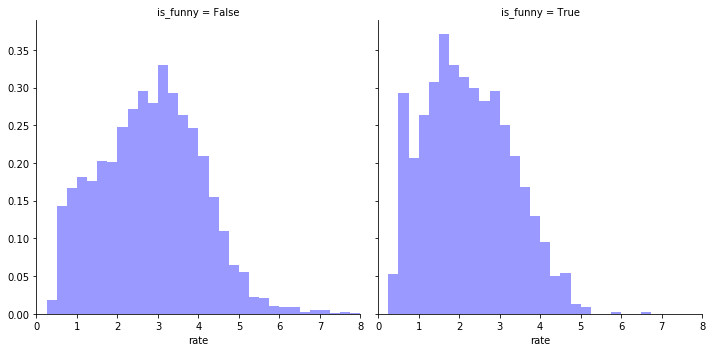

In [8]:
df['rate'] = df['num_words'] / df['length']
g = sns.FacetGrid(df[df['character'] == 'ELAINE'], col='is_funny', height=5, sharex=True, sharey=True, xlim=(0,8))
g.map(sns.distplot, "rate", bins=np.arange(0, 15, 0.25), color='b', kde=False, norm_hist=True)

Our conclusions from these visualization are to add more features to the sentence, such as #words, length (in seconds), speech-rate (words per second), etc.  
We saw that the results actually improved when we gave them these additional features.

## Word Clouds
In order to get meaningful words we want to remove very frequent English words  
First we split by character and see its word-cloud.  
We try to see the patterns of words chosen by each character.  
Are there words that characterize each one?

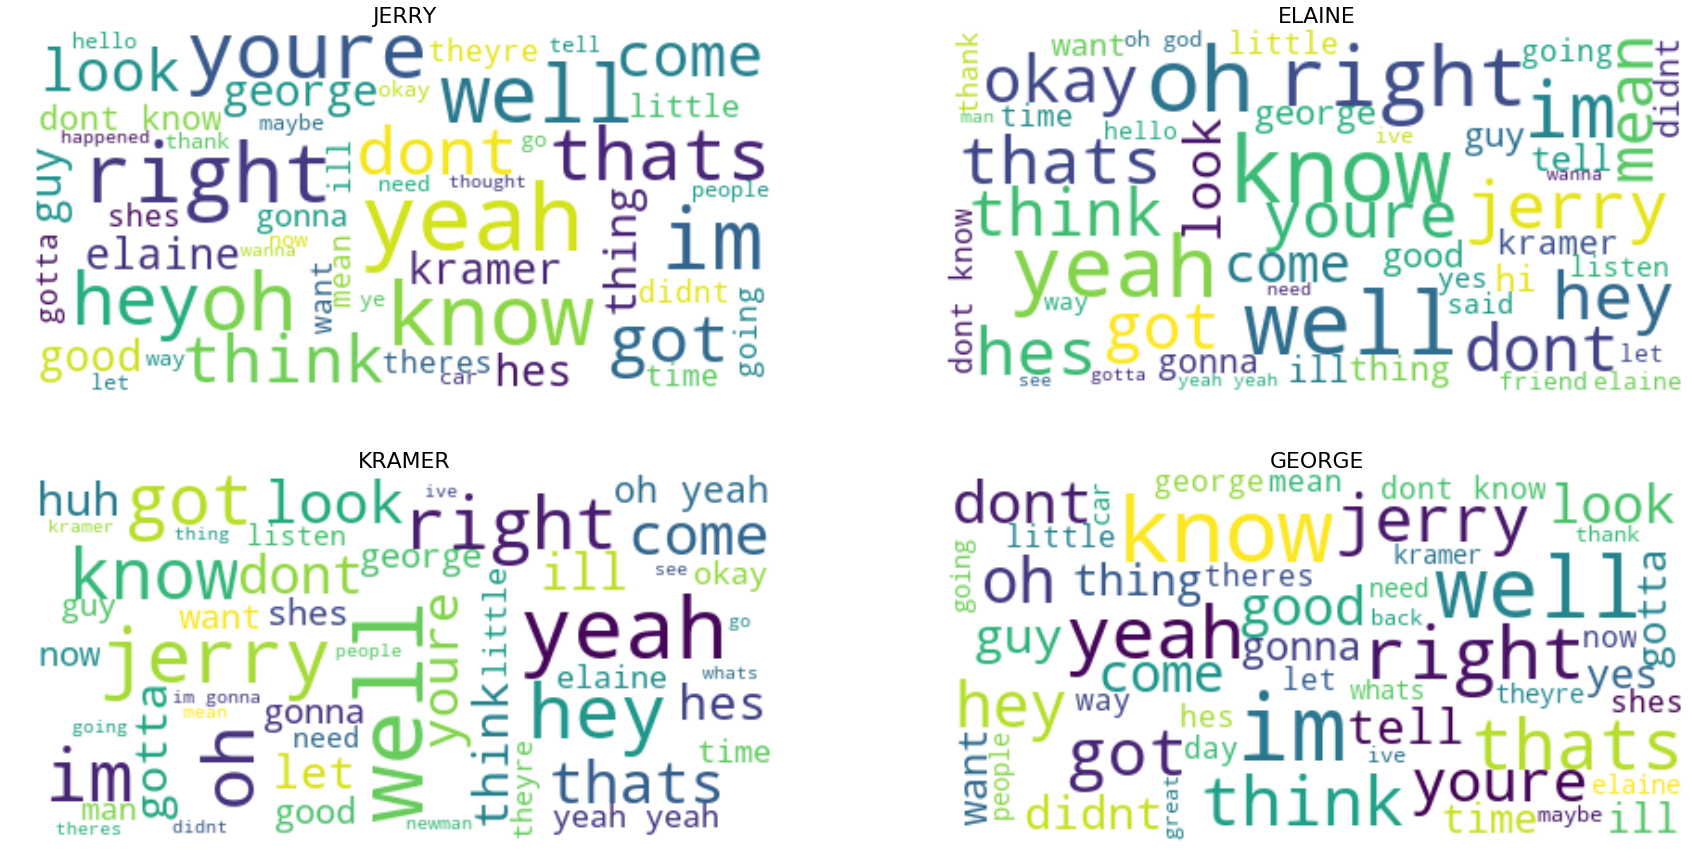

In [19]:
from gensim.parsing import remove_stopwords

plt.figure(figsize=(30, 15))

for i, character in enumerate(["JERRY", "ELAINE", "KRAMER", "GEORGE"]):
    character_df = df[df['character'] == character]
    character_text = " ".join(character_df.txt).lower()
    character_text = remove_stopwords(character_text.replace('\'', ''))  
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(character_text)
    
    plt.subplot(2, 2, i+1)
    plt.title(character, {'fontsize' : 22})
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
              
plt.show()

We can see that the most common words (bigger words in the word-cloud) are common between the characters.  
Indeed, they are general words in English that everyone use, such as 'know', 'yeah', 'right', etc...  
  
Let's try to see if we can see different patterns in the word-clouds of funny/not-funny sentences.  
How are we going to do that?  
We will filter out words that are not inductive for funny/not funny.  
For each word we will calculate the frequency that the character use the word in funny/not funny sentences, and than look only of words that pass a certain threshold (parameter for the "algorithm")

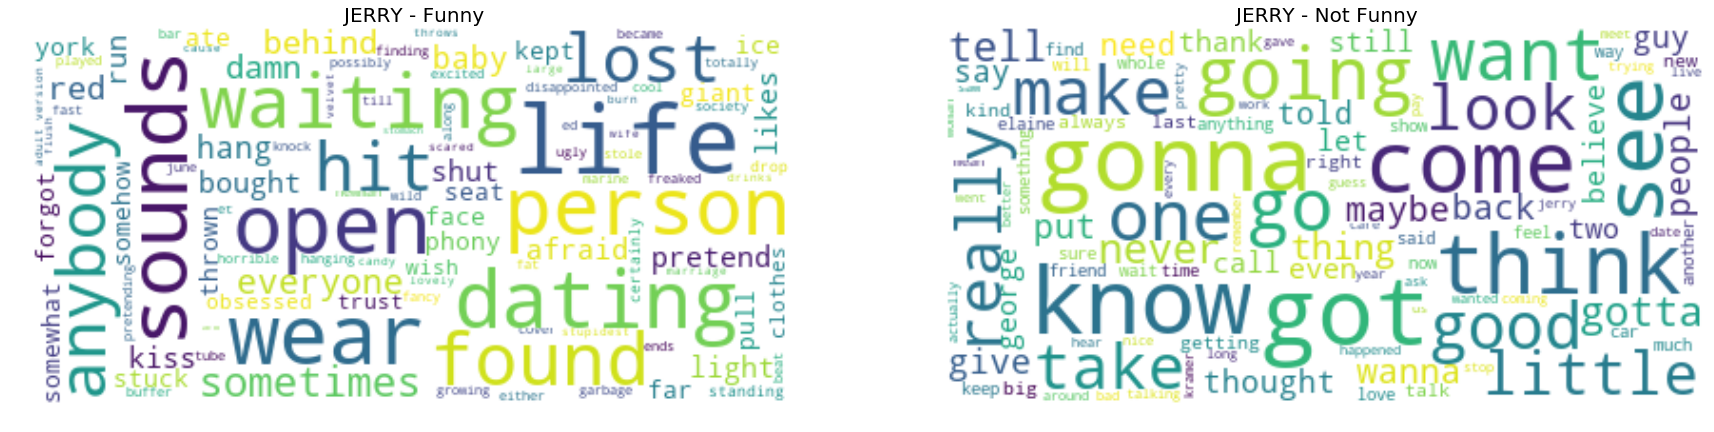

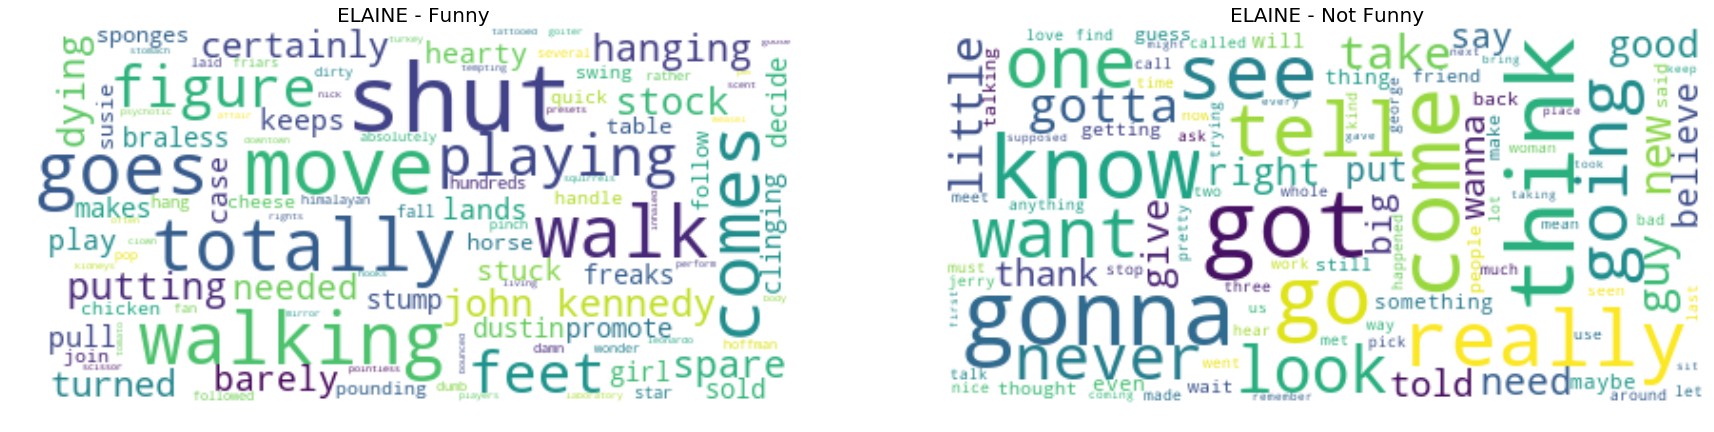

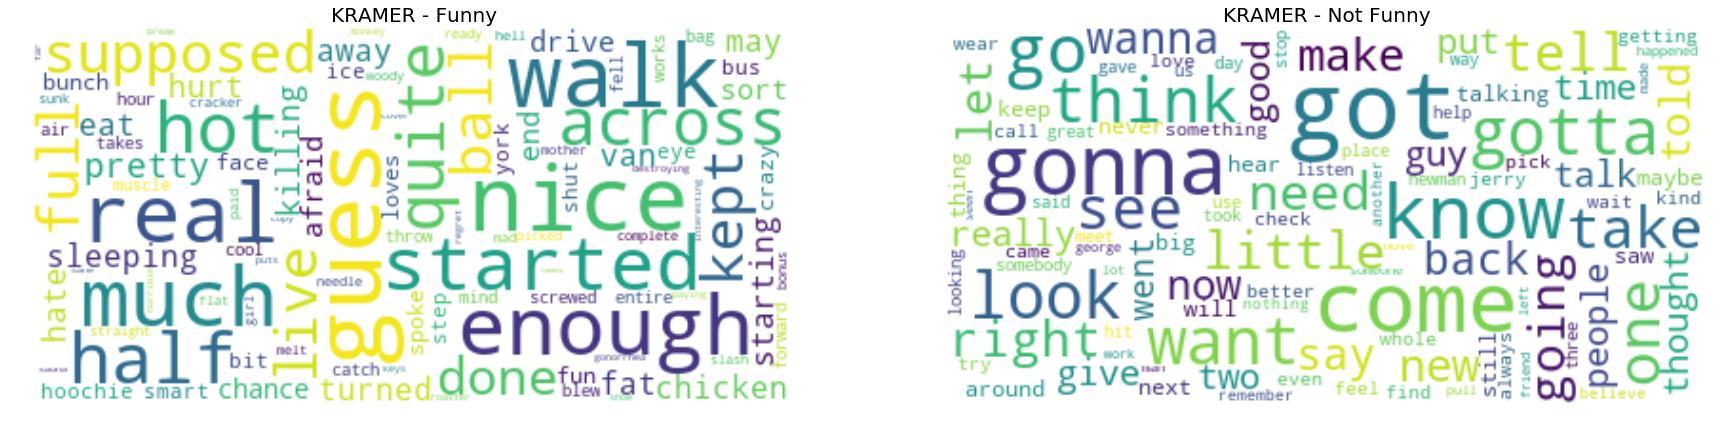

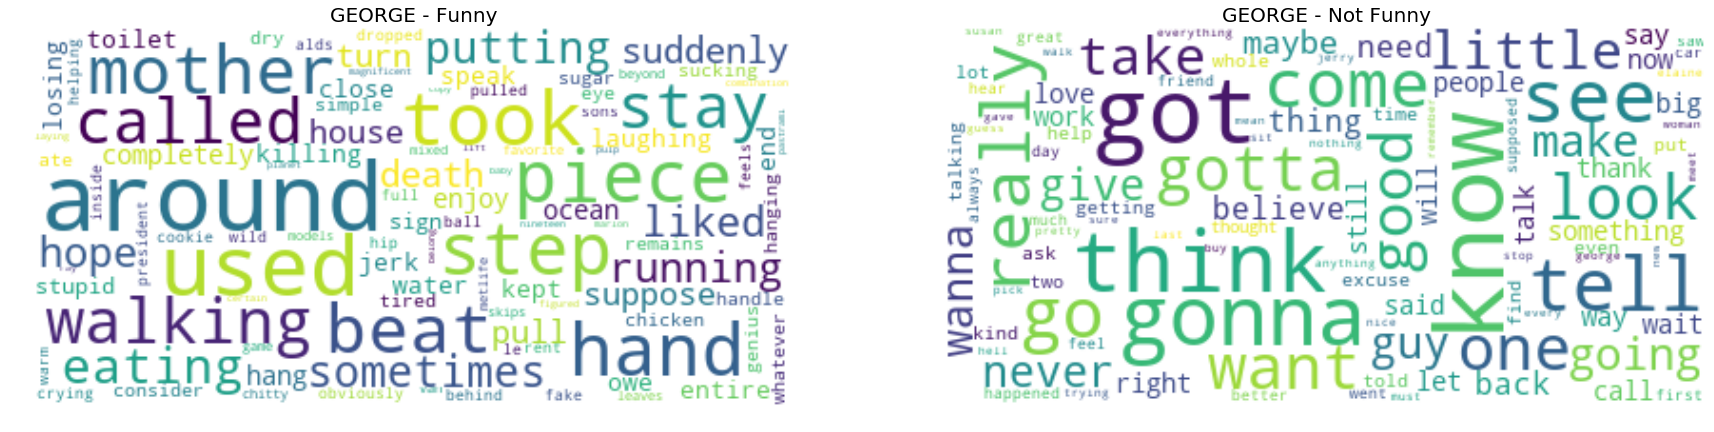

In [10]:
def plot_wordcloud_only_freq(df, character, threshold=0.7):
    """
    Plot word-cloud for the given character
    """
    character_df = df[df['character'] == character]

    character_funny_text = " ".join(character_df[character_df['is_funny'] == True].txt).lower()
    character_not_funny_text = " ".join(character_df[character_df['is_funny'] == False].txt).lower()

    vec = CountVectorizer().fit(character_df.txt)
    bag_of_words = vec.transform(character_df.txt)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = {word : sum_words[0, idx] for word, idx in vec.vocabulary_.items()}

    funny_vec = CountVectorizer().fit(character_df[character_df['is_funny'] == True].txt)
    funny_sum_words = vec.transform(character_df[character_df['is_funny'] == True].txt).sum(axis=0)
    funny_words_freq = {word : funny_sum_words[0, idx] / words_freq[word] for word, idx in vec.vocabulary_.items()}
    freq_funny_words = set([w for w, f in funny_words_freq.items() if f > threshold])
    character_funny_text = ' '.join([word for word in character_funny_text.split(' ') if word in freq_funny_words])

    non_funny_vec = CountVectorizer().fit(character_df[character_df['is_funny'] == False].txt)
    non_funny_sum_words = vec.transform(character_df[character_df['is_funny'] == False].txt).sum(axis=0)
    non_funny_words_freq = {word : non_funny_sum_words[0, idx] / words_freq[word] for word, idx in vec.vocabulary_.items()}
    freq_non_funny_words = set([w for w, f in non_funny_words_freq.items() if f > threshold])
    character_not_funny_text = ' '.join([word for word in character_not_funny_text.split(' ') if word in freq_non_funny_words])

    wordcloud_funny = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(character_funny_text)
    wordcloud_not_funny = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(character_not_funny_text)

    plt.figure(figsize=(30, 30))
    plt.subplot(121)
    plt.title("%s - Funny" %(character), {'fontsize' : 20})
    plt.axis("off")
    plt.imshow(wordcloud_funny, interpolation="bilinear")
    plt.subplot(122)
    plt.title("%s - Not Funny" %(character),{'fontsize' : 20})
    plt.axis("off")
    plt.imshow(wordcloud_not_funny, interpolation="bilinear")
    plt.show()


for character in ["JERRY", "ELAINE", "KRAMER", "GEORGE"]:
    plot_wordcloud_only_freq(df, character, 0.5)

These word-clouds are just fun to look at...  
We can see that there are many common frequent words between funny/not-funny sentences.  
However, we can see some interesting issues for example we can see that:  
&nbsp;&nbsp;&nbsp;&nbsp;When Jerry talks on dating or Elaine tells someone to shut it's usually funny (as we can imagine and see from the data)  
&nbsp;&nbsp;&nbsp;&nbsp;While when any of them say: "think", "really", "gonna" etc... those are regular words that we don't expect to see in funny sentences

# Network Graph
We want to understand the interaction between the different characters.  
Of course all of us saw Seinfeld, but we want to visualize the connections!  
  
We will draw a network graph, which is based on the scenes.  
Each node is a character (from the nature of our data it's only characters that talked), where an edge between _s1_ and _s2_ means that _s1_ and _s2_ were together in the same scene.  (i.e. if we have _n_ characters in a scene we will have (n choose 2) edges from this scene).  
We give weights to the edges according to the amount of times two characters  

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
vec.fit(character_df.txt)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
import networkx as nx
import itertools
from bokeh.io import show, output_notebook, reset_output #output_file, 
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.models import HoverTool,BoxZoomTool, ResetTool, TapTool, Plot, Range1d, Circle, MultiLine
from bokeh.models.sources import ColumnDataSource
from bokeh.palettes import Spectral4

reset_output()
output_notebook()

Loading BokehJS ...

We don't want the graph to crowded so we will filter out characters that doesn't appear often

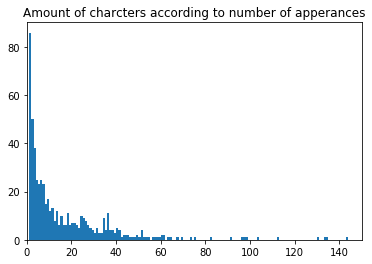

In [20]:
charcter_apperance = df.groupby(['character']).size()
plt.hist(charcter_apperance, bins=np.arange(0,150))
plt.xlim(0,150)
plt.title("Amount of charcters according to number of apperances")
plt.show()

As always, there is no clear cut, we can see that until ~40, there are a lot of characters that we didn't see much.  
After 40, the histogram is more smooth  
So we will make the cut at 40    

In [14]:
min_apperance = 40
freq_apperance = charcter_apperance[charcter_apperance > min_apperance]
print("we filter our {} charcters".format(len(charcter_apperance) - sum(charcter_apperance > min_apperance)))

we filter our 513 charcters


In [17]:
df_scene = getSceneData(df[df.character.isin(freq_apperance.index)].reset_index())
df_scene.head(1)

,index,avg_word_length,character,end,episode_name,episode_num,is_funny,laugh_time,length,line_num,...,txt,global_episode_num,rate,time_from_prev,new_scene,scene_text,scene_characters,n_scene_characters,scene_number_in_episode,global_scene_number
0,0,4.5,JERRY,3.05,The Watch,6,True,3.6,1.944,0,...,"Here's what happened last week, incase you mi...",1,4.62963,0.0,True,"Here's what happened last week, incase you mi...","{MORTY, JERRY}",2,1,1


In [18]:
community_df = df_scene[df_scene['character'].isin(freq_apperance.index)]
community_df = df_scene[['scene_number_in_episode', 'global_scene_number', 'scene_characters', 'is_funny', 'season']]

In [19]:
# add for each scene if the scene funny
funny_scene_df = pd.DataFrame(community_df.groupby(by='global_scene_number')['is_funny'].sum() > 0)
def add_funny_scecne(x, df):
    return [x.is_funny] * sum(df.global_scene_number == x.name)
funny_scene_ls = funny_scene_df.apply(add_funny_scecne, args=(community_df,), axis=1)
funny_scene = [st for row in funny_scene_ls for st in row]
community_df.insert(loc=0, column='is_scene_funny', value=funny_scene)
community_df.head(1)

,is_scene_funny,scene_number_in_episode,global_scene_number,scene_characters,is_funny,season
0,True,1,1,"{MORTY, JERRY}",True,4


In [20]:
graph = []
for idx, row in community_df.iterrows():
    if len(row['scene_characters']) > 1:
        for comb in list(itertools.combinations(row['scene_characters'], 2)):
            # sort by abc so always same order
            char_1, char_2 = sorted(comb)
            graph.append({'char_1' : char_1, 'char_2' : char_2, **row.drop('scene_characters').to_dict()})
df_graph = pd.DataFrame(graph)

weight_graph = df_graph[['char_1', 'char_2']].drop_duplicates()
weight_graph = weight_graph.set_index(['char_1', 'char_2'])
weight_graph['weight'] = df_graph.groupby(['char_1', 'char_2']).size()
weight_graph.reset_index(inplace=True)
weight_graph.head()

,char_1,char_2,weight
0,JERRY,MORTY,826
1,HELEN,MORTY,780
2,HELEN,JERRY,879
3,MORTY,SUSAN,56
4,LEO,SUSAN,56


Although we filtered non frequent characters the graph was still to crowded, so we used another parameter _weight_threshold_ and removed edges with weight smaller than the threshold

In [24]:
weight_threshold = 50
selected_weight_graph = weight_graph[weight_graph.weight > weight_threshold]
g = nx.from_pandas_edgelist(selected_weight_graph, source='char_1', target='char_2', 
                            edge_attr=['char_1', 'char_2', 'weight'])
plot = figure(title="senfiled charcters scenes", x_range=(-2.1,2.1), 
              y_range=(-2.1,2.1), tools="pan", plot_width=700, plot_height=400)


pos = nx.spring_layout
graph = from_networkx(g, pos, scale=2, center=(0,0))

# Change node size porotional to degree
node_size = {k : np.log(v) ** 2 for k,v in g.degree()}
nx.set_node_attributes(g, node_size, 'node_size')
source=ColumnDataSource(pd.DataFrame.from_dict({k:v for k,v in g.nodes(data=True)},orient='index'))
graph.node_renderer.data_source = source

graph.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph.node_renderer.selection_glyph = Circle(size='node_size', fill_color=Spectral4[2])
graph.node_renderer.hover_glyph = Circle(size='node_size', fill_color=Spectral4[1])

graph.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

# set edge weight proprtional to the weight
edge_weight = np.array([g.get_edge_data(a,b)['weight'] for a, b in g.edges()])
edge_weight = edge_weight / 1000
graph.edge_renderer.data_source.data["line_width"] = edge_weight
graph.edge_renderer.glyph.line_width = {'field': 'line_width'}

# Add tooltip for edges with: both nodes & the weight 
graph.inspection_policy = EdgesAndLinkedNodes()
edge_hover_tool = HoverTool(tooltips=[("char_1", "@char_1"), ("char_2", "@char_2"),
                                      ("#scence", "@weight")])
plot.add_tools(edge_hover_tool, BoxZoomTool(), ResetTool())

plot.renderers.append(graph)
show(plot)

ERROR:bokeh.core.validation.check:E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='1549', ...)


Please note that the edges width and nodes sizes are proportional to the weight 
So a character that appears in more scenes has a larger vertex we can see that Elaine, George and Jerry appear in the highest number of scenes.
We can also see that the "clique" between the four main characters (Elaine, George, Jerry and Kramer) had the largest width as expected.

Another interesting insights:  
Newman can be seen mostly with Jerry or Kramer  
Estelle (George mother) mostly talks with George, and after that with Jerry